In [1]:
import pandas as pd
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

from io import StringIO
from dendropy import Tree, TaxonNamespace

import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import geoplot as gplt
import geoplot.crs as gcrs

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

import seaborn as sb
# Set default font size
sb.set(font_scale = .8)
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sb.set_style("white", rc=custom_style)

from itertools import chain

from matplotlib.collections import LineCollection
from matplotlib import markers
from matplotlib.path import Path

import numpy as np

from ete3 import Tree as eteTree
from ete3 import TreeStyle, NodeStyle

full_filename = "data/YFV.trees"
south_filename = "data/YFV_south.trees"
mixed_filename = "data/YFV_south+N.trees"
mixed_alt_filename = "data/YFV_south+N.trees"
full_tip_count = 65
south_tip_count = 30

In [2]:
def read_ids(filename, tip_count):
    # read ids for trees sampled from an MCMC process from a nexus file
    tree_ids_str = !tail  -n +{tip_count * 2 + 13} {filename} | cut -d " "  -f2  | grep "STATE_"| tr "\n" " "
    tree_ids = tree_ids_str[0].split()
    return tree_ids

def read_trees(filename, tip_count):
    # read the nexus strings
    tree_str = !tail  -n +{tip_count * 2 + 13} {filename} | grep "STATE_"  | cut -d " " -f3- 
    return tree_str

def read_header(filename, tip_count):
    # read the nexus header
    header = !head -n +{tip_count * 2 + 12} {filename}
    return header

tree_ids = read_ids(full_filename, full_tip_count)
full_trees = read_trees(full_filename, full_tip_count)
south_trees = read_trees(south_filename, south_tip_count)
mixed_trees = read_trees(mixed_filename, mixed_tip_count)
mixed_alt_trees = read_trees(mixed_alt_filename, mixed_alt_tip_count)

full_header = read_header(full_filename, full_tip_count)
south_header = read_header(south_filename, south_tip_count)
mixed_header = read_header(mixed_filename, mixed_tip_count)
mixed_alt_header = read_header(mixed_alt_filename, mixed_alt_tip_count)

In [3]:
def write_and_read_nexus(filename, header, tree_id, tree_str):
    tns = TaxonNamespace(is_case_sensitive=True)
    # write a temp file containing  tree
    with open(filename, "w") as f:
        for line in header + ["tree " + tree_id + " " + tree_str]:
            f.write(line + "\n");
    # read tree as dendropy tree
    tree = Tree.get(path=filename, schema="nexus",
                    taxon_namespace=tns, case_sensitive_taxon_labels=True, 
                    suppress_internal_node_taxa=False)
    return tree

def get_locations(tree_id, full_str, south_str, #south_str, 
                  mixed_str, mixed_alt_str):
    full_tree = write_and_read_nexus('full_YFV.tmp', full_header, tree_id, full_str)
    south_tree = write_and_read_nexus('south_YFV.tmp', south_header, tree_id, south_str)
    mixed_tree = write_and_read_nexus('mixed_YFV.tmp', mixed_header, tree_id, mixed_str)
    mixed_alt_tree = write_and_read_nexus('mixed_alt_YFV.tmp', mixed_alt_header, tree_id, mixed_alt_str)
    south_tip_ids = list([n.taxon.label for n in south_tree.leaf_node_iter()])
    mixed_tip_ids = list([n.taxon.label for n in mixed_tree.leaf_node_iter()])
    mixed_alt_tip_ids = list([n.taxon.label for n in mixed_alt_tree.leaf_node_iter()])
    
    # get the most recent common ancestor (mrca) for the tip subset
    south_mrca_node = full_tree.mrca(taxon_labels=south_tip_ids)
    mixed_mrca_node = south_mrca_node
    mixed_alt_mrca_node = south_mrca_node
    
    # get the mrca inferred location in the full tree
    south_full_tree_xy = south_mrca_node.annotations["location"].value
    mixed_full_tree_xy = mixed_mrca_node.annotations["location"].value
    mixed_alt_full_tree_xy = mixed_alt_mrca_node.annotations["location"].value
    
    # get the subset tree root node location
    south_tree_xy = south_tree.seed_node.annotations["location"].value
    mixed_mixed_mrca_node = mixed_tree.mrca(taxon_labels=south_tip_ids)
    mixed_mixed_alt_mrca_node = mixed_alt_tree.mrca(taxon_labels=south_tip_ids)
    mixed_tree_xy = mixed_mixed_mrca_node.annotations["location"].value
    mixed_alt_tree_xy = mixed_mixed_alt_mrca_node.annotations["location"].value

    output = [south_full_tree_xy,
              south_tree_xy,
             mixed_full_tree_xy,
             mixed_tree_xy,
             mixed_alt_full_tree_xy,
             mixed_alt_tree_xy]
    flat_output = [tree_id] + [item for sublist in output for item in sublist]
    return flat_output

In [4]:
arr = []
for tree_id, full_str, south_str, mixed_str, mixed_alt_str in zip(tree_ids, 
                 full_trees, 
                 south_trees, 
                 mixed_trees,
                 mixed_alt_trees):
    arr.append(get_locations(tree_id, 
                             full_str, 
                             south_str, 
                             mixed_str,
                            mixed_alt_str))
mrca_xy_df = pd.DataFrame(arr, columns=["tree_id", 
                                        "south_full_tree_x", 
                                        "south_full_tree_y", 
                                        "south_tree_x", 
                                        "south_tree_y",
                                       "mixed_full_tree_x", 
                                        "mixed_full_tree_y", 
                                        "mixed_tree_x", 
                                        "mixed_tree_y",
                                       "mixed_alt_full_tree_x", 
                                        "mixed_alt_full_tree_y", 
                                        "mixed_alt_tree_x", 
                                        "mixed_alt_tree_y"])
# reshape df 
df1 = mrca_xy_df[["tree_id", "south_full_tree_x", "south_full_tree_y"]]
df1["type"] = ["south_full"]*len(df1)
df1.columns = ["tree_id", "Latitude", "Longitude", "type"]
df2 = mrca_xy_df[["tree_id", "south_tree_x", "south_tree_y"]]
df2["type"] = ["south"]*len(df2)
df2.columns = ["tree_id", "Latitude", "Longitude", "type"]
df5 = mrca_xy_df[["tree_id", "mixed_full_tree_x", "mixed_full_tree_y"]]
df5["type"] = ["mixed_full"]*len(df5)
df5.columns = ["tree_id", "Latitude", "Longitude", "type"]
df6 = mrca_xy_df[["tree_id", "mixed_tree_x", "mixed_tree_y"]]
df6["type"] = ["mixed"]*len(df6)
df6.columns = ["tree_id", "Latitude", "Longitude", "type"]
df7 = mrca_xy_df[["tree_id", "mixed_alt_full_tree_x", "mixed_alt_full_tree_y"]]
df7["type"] = ["mixed_alt_full"]*len(df7)
df7.columns = ["tree_id", "Latitude", "Longitude", "type"]
df8 = mrca_xy_df[["tree_id", "mixed_alt_tree_x", "mixed_alt_tree_y"]]
df8["type"] = ["mixed_alt"]*len(df8)
df8.columns = ["tree_id", "Latitude", "Longitude", "type"]
mrca_xy_reshaped_df = pd.concat([df1, 
                                 df2, 
                                 df5, 
                                 df6,
                                df7,
                                df8], ignore_index=True)

# make coords numeric
mrca_xy_reshaped_df[["Longitude", "Latitude"]] = mrca_xy_reshaped_df[["Longitude", "Latitude"]].\
apply(pd.to_numeric, errors='coerce')
# drop illegal coordinates
mrca_xy_reshaped_df = mrca_xy_reshaped_df[(mrca_xy_reshaped_df["Latitude"] > -90) & \
                                          (mrca_xy_reshaped_df["Latitude"] < 90) & \
                                         (mrca_xy_reshaped_df["Longitude"] > -180) & \
                                          (mrca_xy_reshaped_df["Longitude"] < 180)]

# covert to geodataframe, generate Point objects
gdf = gpd.GeoDataFrame(mrca_xy_reshaped_df)
gdf["geometry"] = [Point(x, y) for x,y in zip(mrca_xy_reshaped_df.Longitude, mrca_xy_reshaped_df.Latitude)]
# specify epsg coordinate system for lon, lat coods
# this is the WGS 84 -- WGS84 - World Geodetic System 1984, used in GPS
gdf.crs = {'init': 'epsg:4326'}
# transform from long, lat to projection coordinates (not necessary for geoplot)
# this is  WGS 84 / Pseudo-Mercator - Spherical Mercator(Google Maps, OpenStreetMap) 
gdf = gdf.to_crs(epsg=3857)
# get back transformed xy coords for plotting
# in a projection system
mrca_xy_crs_df = pd.DataFrame(gdf["geometry"].\
apply(lambda point: [float(s.replace("(", "").replace(")", "")) \
for s in str(point).split()[1:]]).tolist(), columns=["Longitude", "Latitude"])
mrca_xy_crs_df[["tree_id", "type"]] = gdf[["tree_id", "type"]] 
mrca_xy_crs_df.head();
mrca_xy_crs_df.to_csv("data/YFV_ALLsubset_vs_fullmrca_location_crs.tsv", sep="\t")

In [5]:
# get all the tip locations
def get_tip_locations(tree_id, full_str, south_str, mixed_str, mixed_alt_str):
    full_tree = write_and_read_nexus('full_YFV.tmp', full_header, tree_id, full_str)
    south_tree = write_and_read_nexus('south_YFV.tmp', south_header, tree_id, south_str)
    mixed_tree = write_and_read_nexus('mixed_YFV.tmp', mixed_header, tree_id, mixed_str)
    mixed_alt_tree = write_and_read_nexus('mixed_alt_YFV.tmp', mixed_alt_header, tree_id, mixed_alt_str)
    full_tip_ids = list([n.taxon.label for n in full_tree.leaf_node_iter()]) 
    south_tip_ids = list([n.taxon.label for n in south_tree.leaf_node_iter()])
    mixed_tip_ids = list([n.taxon.label for n in mixed_tree.leaf_node_iter()])
    mixed_alt_tip_ids = list([n.taxon.label for n in mixed_alt_tree.leaf_node_iter()])
    output = []
    
    for tip_id in full_tip_ids:
        if tip_id in south_tip_ids:
            tip_type = "south"            
        else:
            tip_type = "north"
        tip_node = full_tree.find_node_with_taxon_label(tip_id)
        tip_x, tip_y = tip_node.annotations["location"].value
        output.append([tip_id, tip_type, tip_x, tip_y])
        
    for tip_id in full_tip_ids:
        if tip_id in mixed_tip_ids:
            tip_type = "mixed"
        else:
            tip_type = "non_mixed"
        tip_node = full_tree.find_node_with_taxon_label(tip_id)
        tip_x, tip_y = tip_node.annotations["location"].value
        output.append([tip_id, tip_type, tip_x, tip_y])
        
    for tip_id in full_tip_ids:
        if tip_id in mixed_alt_tip_ids:
            tip_type = "mixed_alt"
        else:
            tip_type = "non_mixed_alt"
        tip_node = full_tree.find_node_with_taxon_label(tip_id)
        tip_x, tip_y = tip_node.annotations["location"].value
        output.append([tip_id, tip_type, tip_x, tip_y])
    return output

for tree_id, full_str, south_str, mixed_str, mixed_alt_str in zip(tree_ids[0],
                                                                 full_trees,
                                                                 south_trees,
                                                                 mixed_trees,
                                                                mixed_alt_trees):
    arr = get_tip_locations(tree_id, full_str, south_str, mixed_str, mixed_alt_str)
    
# order in node annotation is lat;lon
tip_df = pd.DataFrame(arr, columns=["tip_id", "tip_type", "Latitude", "Longitude"])
tip_df[["Longitude", "Latitude"]] = tip_df[["Longitude", "Latitude"]].\
apply(pd.to_numeric, errors='coerce')

# covert to geodataframe, generate Point objects
tip_gdf = gpd.GeoDataFrame(tip_df)
# Point object is specified with lon;lat
tip_gdf["geometry"] = [Point(x, y) for x,y in zip(tip_df.Longitude, tip_df.Latitude)]
# specify epsg coordinate system for lon, lat coods
tip_gdf.crs = {'init': 'epsg:4326'}

# transform from lon,lat to projection coordinates (not necessary for geoplot)
tip_gdf = tip_gdf.to_crs(epsg=3857)

# get back transformed xy coords for plotting
# in a projection system
tip_crs_df = pd.DataFrame(tip_gdf["geometry"].\
apply(lambda point: [float(s.replace("(", "").replace(")", "")) \
for s in str(point).split()[1:]]).tolist(), columns=["Longitude", "Latitude"])
tip_crs_df[["tip_id", "tip_type"]] = tip_gdf[["tip_id", "tip_type"]]
tip_crs_df.to_csv("data/YFV_ALLsubset_vs_fulltip_location.tsv", sep="\t")

In [6]:
def calc_summary_tree(mcmc_tree_filename):
    # create a summary tree from allsampled trees using Bsouth's treeannotator
    !//anaconda3/envs/gpd/bin/treeannotator -burninTrees 1000 {mcmc_tree_filename} {mcmc_tree_filename}_summary.tree

def summary_to_nw_str(mcmc_tree_filename):
    calc_summary_tree(mcmc_tree_filename)
    # convert summary nexus tree to newick for ete3
    tns = TaxonNamespace(is_case_sensitive=True)
    filename = mcmc_tree_filename + "_summary.tree"
    dp_tree = Tree.get(path=filename, 
                       schema="nexus",
                       taxon_namespace=tns,
                       case_sensitive_taxon_labels=True,
                       suppress_internal_node_taxa=False)

    # drop all annotations and illegal characters
    return dp_tree.as_string('newick', suppress_annotations=True)[5:].rstrip("\n")                   

In [7]:
full_nw_str = summary_to_nw_str(full_filename)
south_nw_str = summary_to_nw_str(south_filename)
mixed_nw_str = summary_to_nw_str(mixed_filename)
mixed_alt_nw_str = summary_to_nw_str(mixed_alt_filename)


mrca_xy_crs_df = pd.read_csv("data/YFV_ALLsubset_vs_fullmrca_location_crs.tsv", sep="\t")
tip_crs_df = pd.read_csv("data/YFV_ALLsubset_vs_fulltip_location.tsv", sep="\t")


              TreeAnnotator v1.10.4, 2002-2018
                    MCMC Output analysis
                             by
           Andrew Rambaut and Alexei J. Drummond

             Institute of Evolutionary Biology
                  University of Edinburgh
                     a.rambaut@ed.ac.uk

               Department of Computer Science
                   University of Auckland
                  alexei@cs.auckland.ac.nz


Reading trees (bar assumes 10,000 trees)...
0              25             50             75            100
|--------------|--------------|--------------|--------------|
************************************************************

Total trees read: 10001
Ignoring first 1000 trees.
Total unique clades: 4989

Finding maximum credibility tree...
Analyzing 9001 trees...
0              25             50             75            100
|--------------|--------------|--------------|--------------|
************************************************************

Best tree:

no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
no HPD for proportion > 1 (80.0)
Writing annotated tree....

              T

//anaconda3/envs/gpd/lib/python3.6/site-packages/ipykernel_launcher.py:328: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


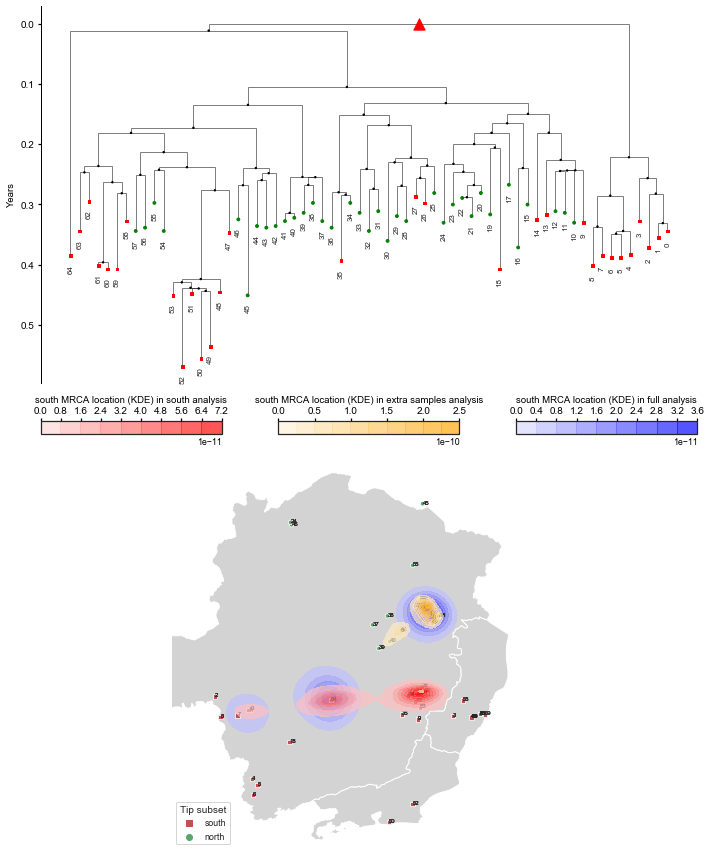

In [8]:
# custom for "mixed" cases
# plot_map_figure("mixed", "non_mixed", full_nw_str, mixed_nw_str, 
#                mrca_str=south_nw_str, mrca_label="south");
ete_tree = eteTree(full_nw_str)
ts = TreeStyle()

style_dict = {
    "south" : ("red", "square", "r", "s", sb.light_palette("red", as_cmap=True)),
    "north" : ("green", "circle", "g", "o", sb.light_palette("green", as_cmap=True)),
    "non_mixed" : ("green", "circle", "b", "o", sb.light_palette("magenta", as_cmap=True))
}

# set node style
nstyle_south = NodeStyle()
nstyle_south['fgcolor'] = style_dict["south"][0]
nstyle_south['size'] = 4
nstyle_south['shape'] = style_dict["south"][1]

nstyle_north = NodeStyle()
nstyle_north['fgcolor'] = style_dict["north"][0]
nstyle_north['size'] = 4
nstyle_north['shape'] = style_dict["north"][1]

nstyle_cmpl = NodeStyle()
nstyle_cmpl['fgcolor'] = style_dict["non_mixed"][0]
nstyle_cmpl["shape"] = style_dict["non_mixed"][1]
nstyle_cmpl['size'] = 4

nstyle_mrca = NodeStyle()
nstyle_mrca['fgcolor'] = 'red'
nstyle_mrca['size'] = 16
nstyle_mrca['shape'] = '^'

nstyle_int = NodeStyle()
nstyle_int['fgcolor'] = 'black'
nstyle_int['size'] = 2
nstyle_int['shape'] = "circle"

subset_nw_str = mixed_alt_nw_str
ete_full_tips = [n for n in ete_tree.iter_leaf_names()]
name_to_num = dict(zip(ete_full_tips, range(len(ete_full_tips))))
ete_subset_tree = eteTree(subset_nw_str)
ete_subset_tips =  [n for n in ete_subset_tree.iter_leaf_names()]
ete_tree.set_style(ts)

mrca_ete_tree = eteTree(south_nw_str)
mrca_subset = [n for n in mrca_ete_tree.iter_leaf_names()]
mrca = ete_tree.get_common_ancestor(*mrca_subset)

for n in ete_tree.traverse():
    if n.is_leaf() and n.name in ete_subset_tips:
        if n.name in mrca_subset:
            n.set_style(nstyle_south)
        else:
            n.set_style(nstyle_north)
    elif n.is_leaf():
        n.set_style(nstyle_cmpl)
    elif n == mrca:
        n.set_style(nstyle_mrca)
    else:
        n.set_style(nstyle_int)

name_to_num = dict(zip(ete_full_tips, range(len(ete_full_tips))))
fig = plt.figure(figsize=(10, 12))
widths = [1, 1, 1]
heights = [30, 1, 30]
gs = fig.add_gridspec(ncols=3, nrows=3,
                      width_ratios=widths,
                      height_ratios=heights,
                     hspace=0.01)
tree_ax = fig.add_subplot(gs[0, :])
map_ax = fig.add_subplot(gs[2, :])
cax_red = fig.add_subplot(gs[1, 0])
cax_org = fig.add_subplot(gs[1, 1])
cax_blue = fig.add_subplot(gs[1, 2])

# add tree
def round_sig(x, sig=2):
    return round(x, sig - int(np.floor(np.log10(abs(x)))) - 1)

def to_coord(x, y, xmin, xmax, ymin, ymax, plt_xmin, plt_ymin, plt_width, plt_height):
    x = (x - xmin) / (xmax - xmin) * plt_width  + plt_xmin
    y = (y - ymin) / (ymax - ymin) * plt_height + plt_ymin
    return x, y

cstyle = NodeStyle()
align_names=False
name_offset=None
max_dist=None
font_size=3

def __draw_edge_nm(c, y):
    h = node_pos[c]
    vlinec.append(((h, y), (h, y + c.dist)))
    vlines.append(cstyle)
    return (h, y + c.dist)

def __draw_edge_md(c, x):
    h = node_pos[c]
    if c in cut_edge:
        offset = max_x / 600.
        hlinec.append(((x, h), (x + c.dist / 2 - offset, h)))
        hlines.append(cstyle)
        hlinec.append(((x + c.dist / 2 + offset, h), (x + c.dist, h)))
        hlines.append(cstyle)
        hlinec.append(((x + c.dist / 2, h - 0.05), (x + c.dist / 2 - 2 * offset, h + 0.05)))
        hlines.append(cstyle)
        hlinec.append(((x + c.dist / 2 + 2 * offset, h - 0.05), (x + c.dist / 2, h + 0.05)))
        hlines.append(cstyle)
        tree_ax.text(x + c.dist / 2, h - 0.07, '+%g' % max_dist, va='top', 
                 ha='center', rotation=90, size=2. * font_size / 3)
    else:
        hlinec.append(((x, h), (x + c.dist, h)))
        hlines.append(cstyle)
    return (x + c.dist, h)

__draw_edge = __draw_edge_nm if max_dist is None else __draw_edge_md

vlinec = []
vlines = []
hlinec = []
hlines = []
nodes = []
nodex = []
nodey = []
ali_lines = []

# to align leaf names
tree = ete_tree
max_y = max(n.get_distance(tree) for n in tree.iter_leaves())
# extra pad
max_y = max_y + max_y * .1

coords = {}
# position on x axis
node_pos = dict((n2, i) for i, n2 in enumerate(tree.get_leaves()[::-1]))
node_list = tree.iter_descendants(strategy='postorder')
node_list = chain(node_list, [tree])

# reduce branch length
cut_edge = set()
if max_dist is not None:
    for n in tree.iter_descendants():
        if n.dist > max_dist:
            n.dist -= max_dist
            cut_edge.add(n)

if name_offset is None:
    name_offset = max_y / 30.
# draw tree
for n in node_list:
    style = n._get_style()
    # distance from root on y-axis
    y = __builtin__.sum(n2.dist for n2 in n.iter_ancestors()) + n.dist
    if n.is_leaf():
        x = node_pos[n]
        tree_ax.text(x,
                     y + name_offset,
                     name_to_num[n.name],
                     ha="center",
                     va='center',
                     rotation=90,
                     size=8)
    else:
        x = np.mean([node_pos[n2] for n2 in n.children])
        node_pos[n] = x

        # draw horizontal line
        hlinec.append(((node_pos[n.children[0]], y), (node_pos[n.children[-1]], y)))
        hlines.append(style)

        # draw vertical lines
        for child in n.children:
            cstyle = child._get_style()
            coords[child] = __draw_edge(child, y)
    nodes.append(style)
    nodex.append(x)
    nodey.append(y)

# draw root
__draw_edge(tree, 0)

lstyles = ['-', '--', ':']
hline_col = LineCollection(hlinec, colors=[l['hz_line_color'] for l in hlines], 
                          linestyle=[lstyles[l['hz_line_type']] for l in hlines],
                         linewidth=[(l['hz_line_width'] + 1.) / 2 for l in hlines])
vline_col = LineCollection(vlinec, colors=[l['vt_line_color'] for l in vlines], 
                         linestyle=[lstyles[l['vt_line_type']] for l in vlines],
                          linewidth=[(l['vt_line_width'] + 1.) / 2 for l in vlines])
ali_line_col = LineCollection(ali_lines, colors='k')

tree_ax.add_collection(hline_col)
tree_ax.add_collection(vline_col)
tree_ax.add_collection(ali_line_col)

nshapes = dict((('circle', 'o'), ('square', 's'), ('sphere', 'o')))
shapes = set(n['shape'] for n in nodes)
for shape in shapes:
    indexes = [i for i, n in enumerate(nodes) if n['shape'] == shape]
    scat = tree_ax.scatter([nodex[i] for i in indexes], 
                       [nodey[i] for i in indexes], 
                       s=0, marker=nshapes.get(shape, shape))
    scat.set_sizes([(nodes[i]['size'])**2 / 2 for i in indexes])
    scat.set_color([nodes[i]['fgcolor'] for i in indexes])
    scat.set_zorder(10)

# custom y axis
tree_ax.set_frame_on(False)    
tree_ax.get_xaxis().set_visible(False)
tree_ax.invert_yaxis()
xmin, xmax = tree_ax.get_xaxis().get_view_interval()
ymin, ymax = tree_ax.get_yaxis().get_view_interval()
tree_ax.add_artist(plt.Line2D((xmin, xmin), (ymin, ymax), color='black', linewidth=2))
tree_ax.tick_params(labelsize=10, length=3, left=True)
tree_ax.set_ylabel("Years")

#from http://www.naturalearthdata.com/downloads/10m-cultural-vectors/
brazil_states = gpd.read_file("data/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")
brazil_states = brazil_states[brazil_states["name_en"].isin(["Rio de Janeiro", "Minas Gerais","EspÃ\xadrito Santo"])].to_crs(epsg=3857)

brazil_states.plot(linewidth=1,
        edgecolor='white',
        facecolor='lightgray',
        ax=map_ax); 


# drop ~10% of sampled trees (10k) as MCMC burn-in
def drop_burnin(df, drop_ratio = .1):
    drop_num = int(len(df)*drop_ratio)
    return df[drop_num:]
full_df = mrca_xy_crs_df[mrca_xy_crs_df["type"] == "south_full"]
full_df = drop_burnin(full_df) # south MRC location in full tree
subset_df = mrca_xy_crs_df[mrca_xy_crs_df["type"] == "south"]
subset_df = drop_burnin(subset_df)# south tree root location
rescue_df = mrca_xy_crs_df[mrca_xy_crs_df["type"] == "mixed_alt"] 
rescue_df =drop_burnin(rescue_df) # south MRC location in YFV_south+52south.trees

# have to flip lat;lon -> lon;lat when plotting
sb.kdeplot(subset_df.Longitude,
           subset_df.Latitude,
           cmap=sb.light_palette("red", as_cmap=True),
           shade=True, 
           shade_lowest=False,  
           alpha=.7, 
           cbar=True, 
           cbar_ax=cax_red,
           cbar_kws={"orientation": "horizontal"},
           zorder=5,
           ax=map_ax);

sb.kdeplot(rescue_df.Longitude,
           rescue_df.Latitude,
           cmap=sb.light_palette("orange", as_cmap=True),
           shade=True, 
           shade_lowest=False,  
           alpha=.7, 
           cbar=True, 
           cbar_ax=cax_org,
           cbar_kws={"orientation": "horizontal"},
           zorder=5,
           ax=map_ax);

sb.kdeplot(full_df.Longitude, 
           full_df.Latitude, 
           cmap=sb.light_palette("blue", as_cmap=True), 
           shade=True, 
           shade_lowest=False, 
           alpha=.7, 
           cbar=True, 
           cbar_ax=cax_blue,
           cbar_kws={"orientation": "horizontal"},
           #zorder=5,
           ax=map_ax);

cax_red.xaxis.set_ticks_position('top')
cax_red.xaxis.set_label_position('top')
cax_red.tick_params(labelsize=10, length=3, left=True, labelleft=True, 
                    right=False, labelright=False)
cax_red.set_xlabel("south MRCA location (KDE) in south analysis")


cax_org.xaxis.set_ticks_position('top')
cax_org.xaxis.set_label_position('top')
cax_org.tick_params(labelsize=10, length=3, left=True, labelleft=True, 
                    right=False, labelright=False)
cax_org.set_xlabel("south MRCA location (KDE) in extra samples analysis")

cax_blue.xaxis.set_ticks_position('top')
cax_blue.xaxis.set_label_position('top')
cax_blue.tick_params(labelsize=10, length=3, right=True, labelright=True)
cax_blue.set_xlabel("south MRCA location (KDE) in full analysis")

# show tip location w/t scatterplot
tip_df = tip_crs_df[(tip_crs_df["tip_type"] == "south") |\
                    (tip_crs_df["tip_type"] == "north")]
sb.scatterplot(x=tip_df.Longitude, 
               y=tip_df.Latitude,
               hue=tip_df.tip_type,
               palette = {"north" : "g",
                          "south" : "r"},
               style=tip_df.tip_type,
               markers ={"north" : style_dict["north"][3],
                         "south" : style_dict["south"][3]},
               s=20,
               ax = map_ax)

# annotate scatter with tip_idx label
name_to_num = dict([(k.replace("'", ""), name_to_num[k]) for k in name_to_num.keys()])
generic_labels = [name_to_num[l] for l in tip_crs_df["tip_id"]]
X=tip_crs_df.Longitude.values
Y=tip_crs_df.Latitude.values
for i, label in enumerate(generic_labels):
    map_ax.annotate(label, 
                   (X[i], 
                     Y[i]),
                  fontsize=6)


# custom legend
handles, labels = map_ax.get_legend_handles_labels()
map_ax.legend(handles[1:],  labels[1:], 
              loc='lower left', 
              title="Tip subset")
map_ax.set_xlim(left=-5400000, right=-4250000)
map_ax.set_ylim(bottom=-2700000, top=-1600000) 
map_ax.set_axis_off()
gs.tight_layout(fig)
fig.show();
fig.savefig("figures/YFV_south1_vs_fullmrca_vs_south+52south_location_kde_tree.pdf", 
            format="pdf", dpi="figure", bbox_inches="tight")
fig.savefig("figures/YFV_south1_vs_fullmrca_vs_south+52south_location_kde_tree.svg", 
            format="svg", dpi="figure", bbox_inches="tight")